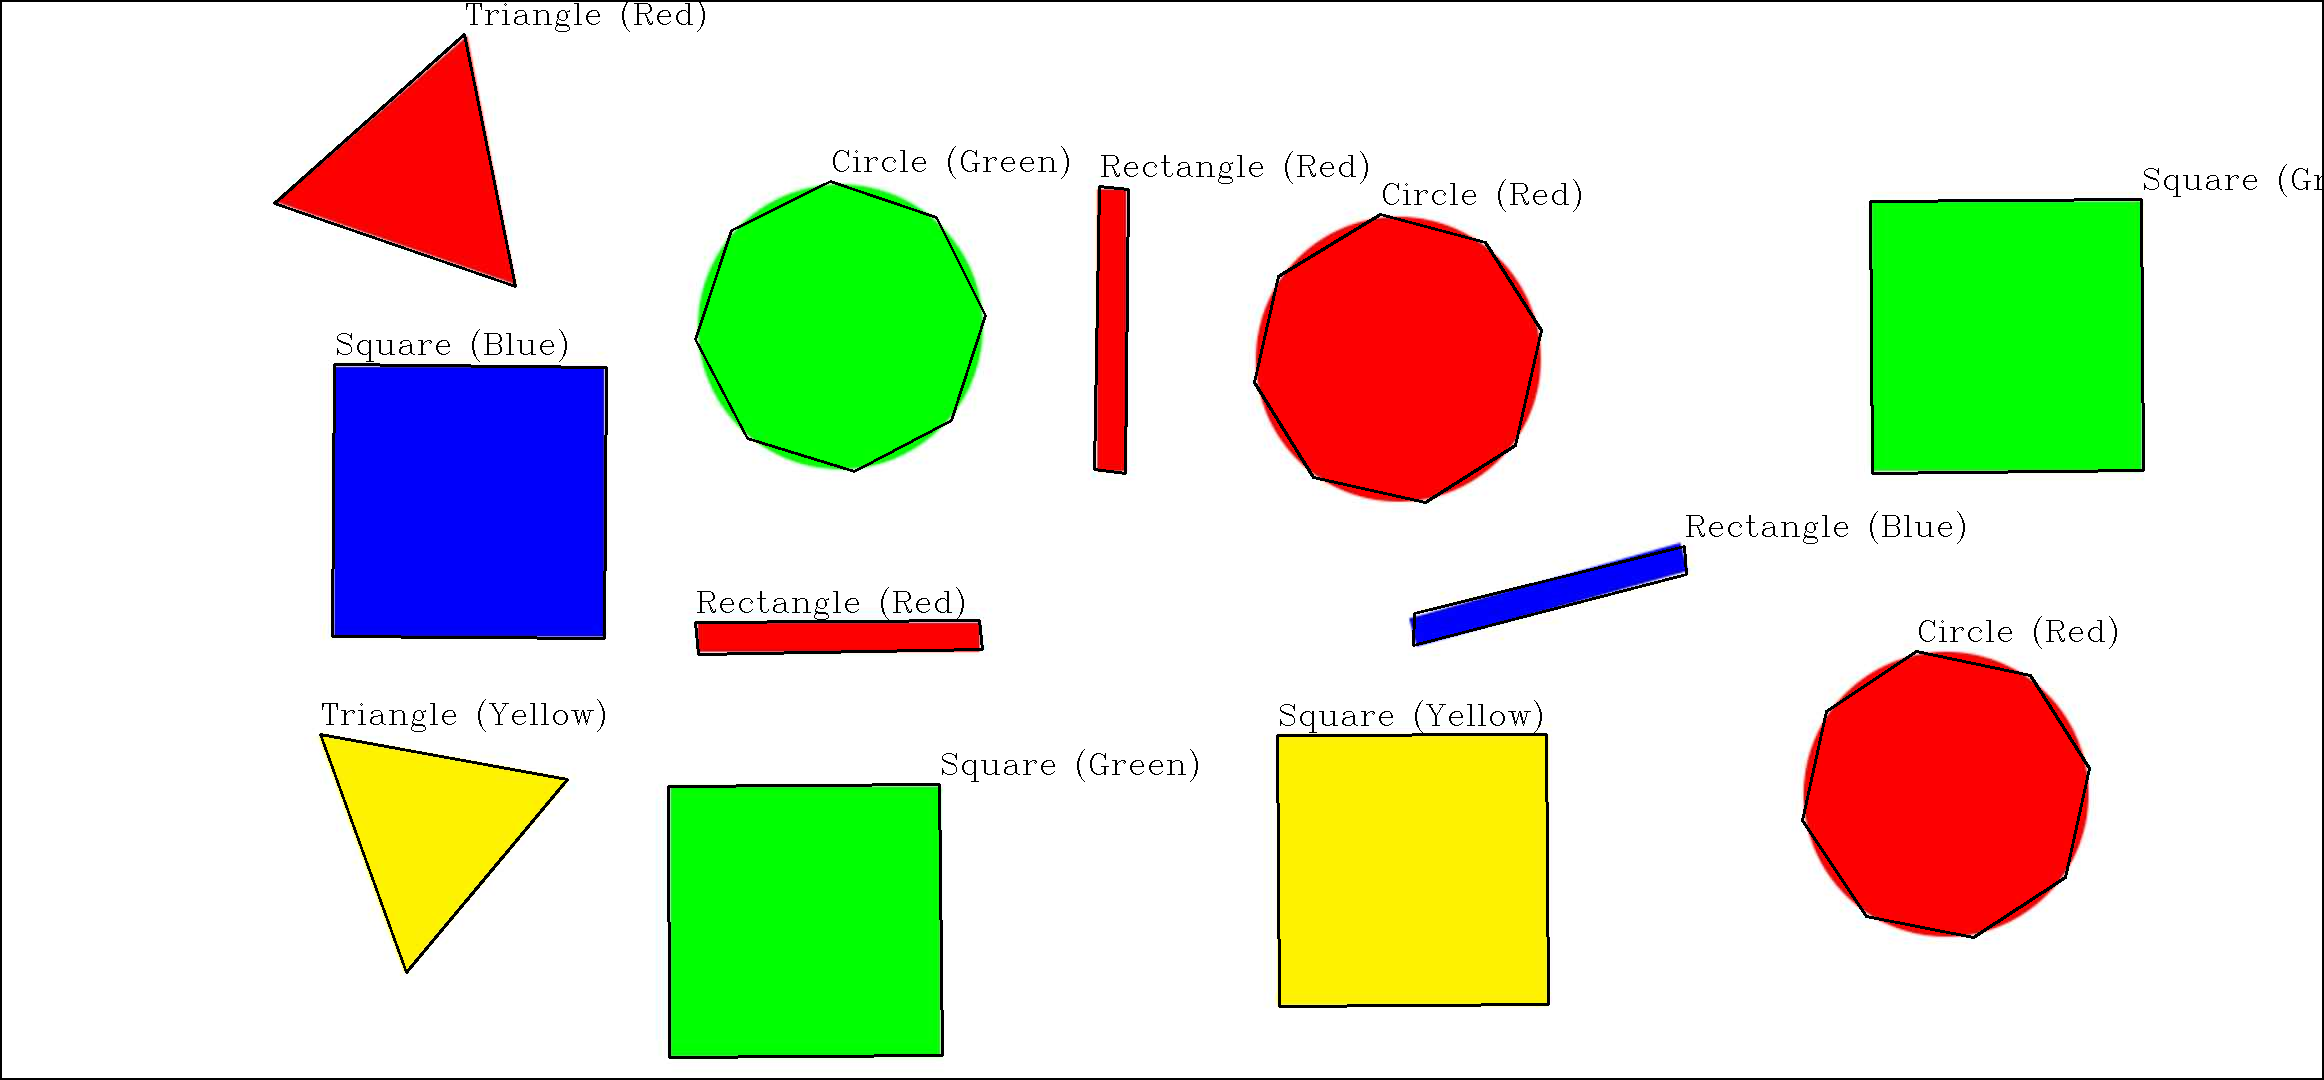

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Define color ranges in HSV
color_ranges = {
    'red': ([0, 100, 100], [10, 255, 255]),
    'green': ([40, 50, 50], [90, 255, 255]),
    'blue': ([90, 50, 50], [130, 255, 255]),
    'yellow': ([20, 100, 100], [30, 255, 255])
}

# Define BGR colors for drawing text
colors = {
    'red': (0, 0, 255),
    'green': (0, 255, 0),
    'blue': (255, 0, 0),
    'yellow': (0, 255, 255)
}

# Load the image
img = cv2.imread("/content/drive/MyDrive/test.jpg")

# Check if the image was loaded successfully
if img is None:
    print("Error: Image not found or failed to load.")
else:
    # Convert the image to grayscale and HSV
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply Gaussian Blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image and find contours
    _, thrash = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Process contours and draw shapes
    img_shape = img.copy()
    for contour in contours:
        if cv2.contourArea(contour) < 100:
            continue

        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        x, y = approx.ravel()[0], approx.ravel()[1] - 10

        # Detect shape
        if len(approx) == 3:
            shape_name = "Triangle"
        elif len(approx) == 4:
            x1, y1, w, h = cv2.boundingRect(approx)
            aspectRatio = float(w) / h
            if 0.95 <= aspectRatio <= 1.05:
                shape_name = "Square"
            else:
                shape_name = "Rectangle"
        else:
            shape_name = "Circle"

        # Create a mask for the contour
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [approx], -1, 255, -1)  # Fill the contour in the mask

        # Calculate the mean color inside the contour
        mean_color_bgr = cv2.mean(img, mask=mask)[:3]  # Get the mean color in BGR

        # Convert the mean color to HSV to check color ranges
        mean_color_hsv = cv2.cvtColor(np.uint8([[mean_color_bgr]]), cv2.COLOR_BGR2HSV)[0][0]

        # Detect color by comparing with pre-defined HSV ranges
        color_name = "Unknown"
        for color, (lower, upper) in color_ranges.items():
            lower_bound = np.array(lower)
            upper_bound = np.array(upper)
            # Reshape mean_color_hsv into 3D format for inRange function
            mean_color_hsv_reshaped = np.array([[mean_color_hsv]])  # Reshape to (1,1,3)
            if cv2.inRange(mean_color_hsv_reshaped, lower_bound, upper_bound) == 255:
                color_name = color
                break

        # Draw the contour and label the shape with the color
        cv2.drawContours(img_shape, [approx], 0, (0, 0, 0), 2)
        label = f"{shape_name} ({color_name.capitalize()})"
        cv2.putText(img_shape, label, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 1)

    # Display the final image with shapes and colors
    cv2_imshow(img_shape)

    # Wait for a key press and close all windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()
